# Analyzing Ticker Trends in Different Approaches

## Task 0a: import library

In [109]:
!pip install numpy --ignore-installed numpy




  Using cached numpy-2.2.4-cp312-cp312-macosx_14_0_arm64.whl.metadata (62 kB)
Using cached numpy-2.2.4-cp312-cp312-macosx_14_0_arm64.whl (5.2 MB)


In [110]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import datetime
import numpy as np
np.float_ = np.float64

from prophet import Prophet
import nltk
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import requests
import numpy
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob

# Download necessary NLTK data
nltk.download('vader_lexicon')
nltk.download('punkt')



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/goodtam8/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /Users/goodtam8/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Task 0b: get data

In [111]:
# You can find the yfinance symbols here: https://finance.yahoo.com/lookup/

def get_data(symbol, period):
    df = yf.download(symbol, start=datetime.datetime.today()-datetime.timedelta(days=period), end=datetime.datetime.today())
    df.reset_index(inplace=True)
    df.columns = df.columns.map(lambda x: x[0])
    return df

# symbol = 'BTC-USD'
# symbol = 'AAPL'
symbol = 'AAPL'
macd_bydate=get_data(symbol,365)
df = get_data(symbol, 365*10)
df

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Date,Close,High,Low,Open,Volume
0,2015-04-20,28.496611,28.612740,27.953924,28.043256,188217200
1,2015-04-21,28.342520,28.630611,28.288920,28.608280,129740400
2,2015-04-22,28.724405,28.780237,28.210753,28.360382,150618000
3,2015-04-23,28.958902,29.126398,28.617211,28.652945,183083600
4,2015-04-24,29.095131,29.173297,28.860636,29.142031,178103600
...,...,...,...,...,...,...
2509,2025-04-09,198.850006,200.610001,171.889999,171.949997,184395900
2510,2025-04-10,190.419998,194.779999,183.000000,189.070007,121880000
2511,2025-04-11,198.149994,199.539993,186.059998,186.100006,87435900
2512,2025-04-14,202.520004,212.940002,201.160004,211.440002,101352900


## Task 1a: get MACD(Moving Average Convergence Divergence) and Signal Line

In [112]:
def get_MACD():
    df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['EMA12']-df['EMA26']
    df['Signal line'] = df['MACD'].ewm(span=9, adjust=False).mean()

get_MACD()
df
macd_bydate['Date'] = pd.to_datetime(macd_bydate['Date'])
macd_bydate.set_index('Date', inplace=True)

In [113]:
##Task 1c: get MACD(Moving Average Convergence Divergence) and Signal Line(in different time frame)

In [114]:
weekly = macd_bydate['Close'].resample('W').last()
monthly = macd_bydate['Close'].resample('ME').last()
quarterly = macd_bydate['Close'].resample('QE').last()
# Calculate MACD for different timeframes
def calculate_macd(price_series, fast=12, slow=26, signal=9):
    ema_fast = price_series.ewm(span=fast, adjust=False).mean()
    ema_slow = price_series.ewm(span=slow, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal, adjust=False).mean()
    return macd_line, signal_line

# Calculate MACD for each timeframe
weekly_macd, weekly_signal = calculate_macd(weekly)
monthly_macd, monthly_signal = calculate_macd(monthly)
quarterly_macd, quarterly_signal = calculate_macd(quarterly)


In [115]:
def get_trend(series):
    return series.diff().apply(lambda x: 'Up' if x > 0 else ('Down' if x < 0 else 'Flat'))

monthly_trend = get_trend(monthly)
quarterly_trend = get_trend(quarterly)



In [116]:
monthly_summary = monthly_trend.value_counts()
quarterly_summary = quarterly_trend.value_counts()


## Task 1b: plot MACD(Moving Average Convergence Divergence) and Signal Line

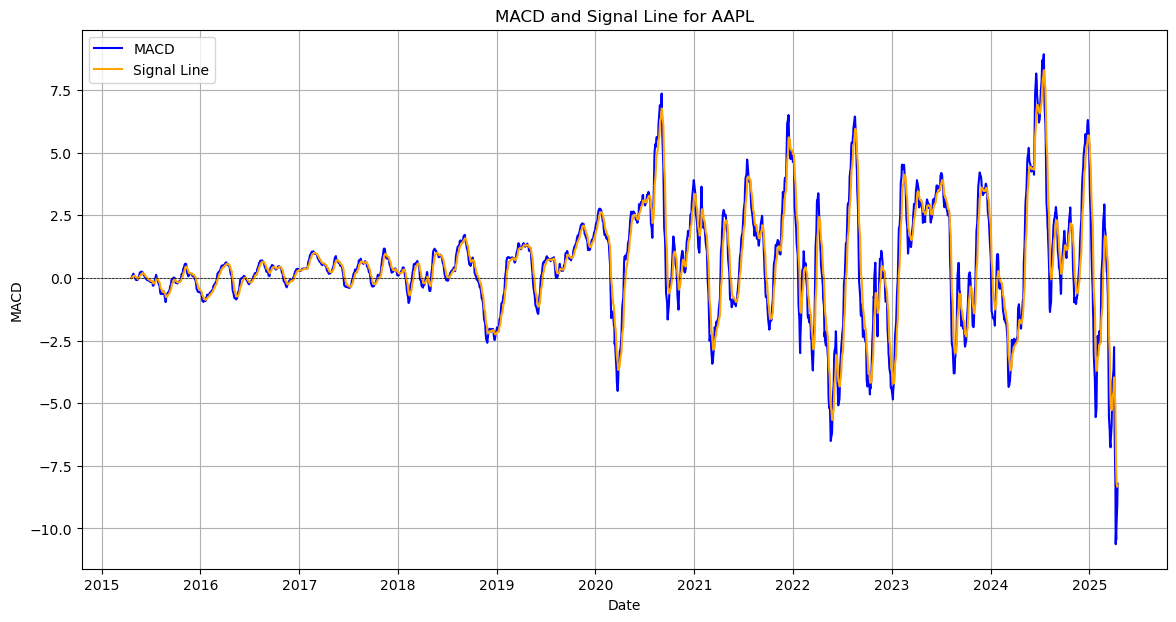

In [138]:
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['MACD'], label='MACD', color='blue')
plt.plot(df['Date'], df['Signal line'], label='Signal Line', color='orange')
plt.axhline(0, color='black', lw=0.5, ls='--')
plt.title(f'MACD and Signal Line for {symbol}')
plt.xlabel('Date')
plt.ylabel('MACD')
plt.legend()
plt.grid()
plt.show()

In [118]:
## Task 1b: plot MACD(Moving Average Convergence Divergence) and Signal Line(in time-frame basis)

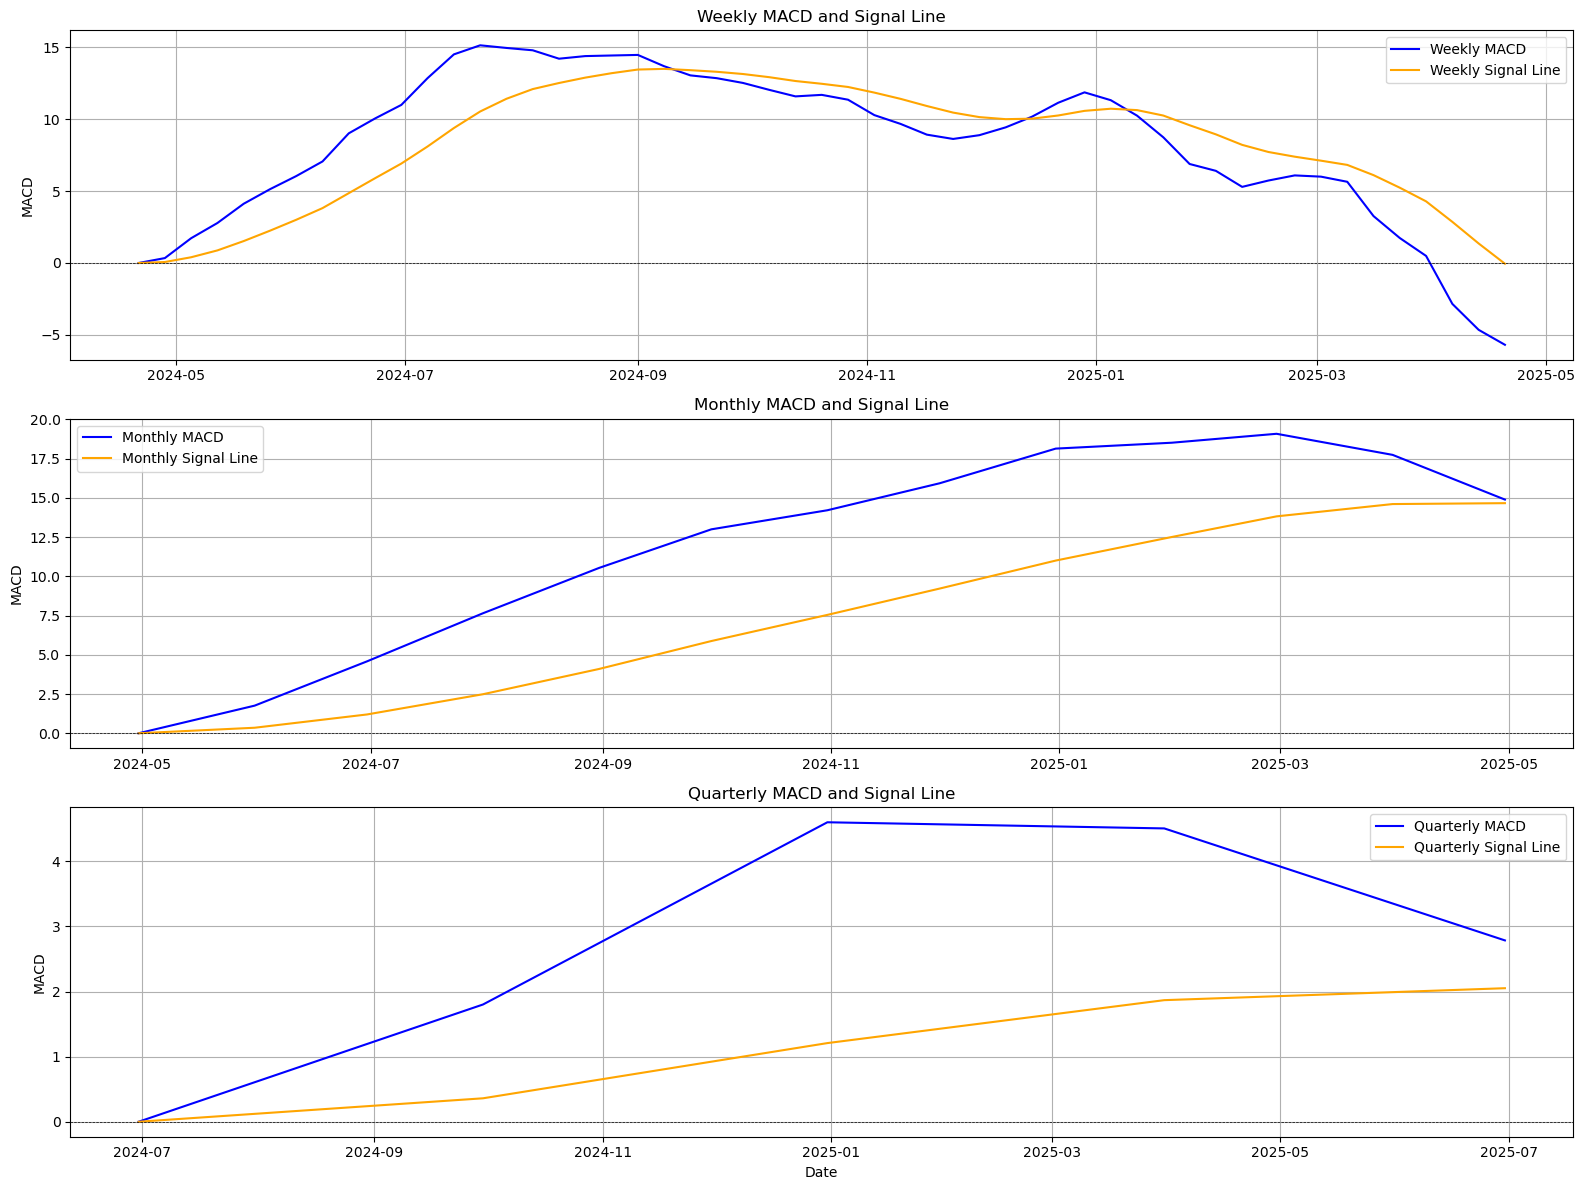

In [119]:
plt.figure(figsize=(16, 12))

# --- Weekly MACD ---
plt.subplot(3, 1, 1)
plt.plot(weekly_macd.index, weekly_macd.values, label='Weekly MACD', color='blue')
plt.plot(weekly_signal.index, weekly_signal.values, label='Weekly Signal Line', color='orange')
plt.axhline(0, color='black', lw=0.5, ls='--')
plt.title('Weekly MACD and Signal Line')
plt.ylabel('MACD')
plt.legend()
plt.grid(True)

# --- Monthly MACD ---
plt.subplot(3, 1, 2)
plt.plot(monthly_macd.index, monthly_macd.values, label='Monthly MACD', color='blue')
plt.plot(monthly_signal.index, monthly_signal.values, label='Monthly Signal Line', color='orange')
plt.axhline(0, color='black', lw=0.5, ls='--')
plt.title('Monthly MACD and Signal Line')
plt.ylabel('MACD')
plt.legend()
plt.grid(True)

# --- Quarterly MACD ---
plt.subplot(3, 1, 3)
plt.plot(quarterly_macd.index, quarterly_macd.values, label='Quarterly MACD', color='blue')
plt.plot(quarterly_signal.index, quarterly_signal.values, label='Quarterly Signal Line', color='orange')
plt.axhline(0, color='black', lw=0.5, ls='--')
plt.title('Quarterly MACD and Signal Line')
plt.xlabel('Date')
plt.ylabel('MACD')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


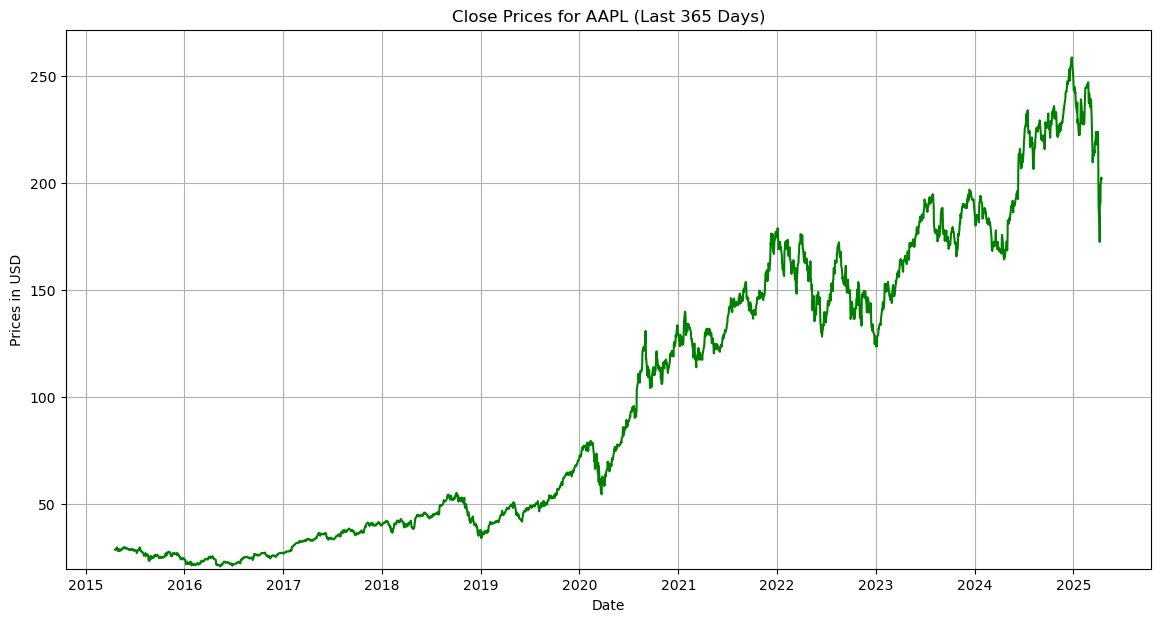

In [120]:
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Close'], color='green')
plt.axhline(0, color='black', lw=0.5, ls='--')
plt.title(f'Close Prices for {symbol} (Last 365 Days)')
plt.xlabel('Date')
plt.ylabel('Prices in USD')
plt.grid()
plt.ylim(top=df['Close'].max() * 1.05)
plt.ylim(bottom=df['Close'].min() * 0.95)
plt.show()

## Task 2a: get RSI(Relative Strength Index)

In [121]:
def get_RSI():
    df['Changes'] = df['Close'].diff()
    for i in range(len(df)):
        df.at[df.index[i], 'Average gain'] = df.loc[:df.index[i], 'Changes'][df.loc[:df.index[i], 'Changes'] >= 0].mean()
        df.at[df.index[i], 'Average loss'] = df.loc[:df.index[i], 'Changes'][df.loc[:df.index[i], 'Changes'] < 0].mean()
    df['RS'] = df['Average gain']/(df['Average loss']*-1)
    df['RSI'] = 100-(100/(1+df['RS']))
    
get_RSI()
df

,Date,Close,High,Low,Open,Volume,EMA12,EMA26,MACD,Signal line,Changes,Average gain,Average loss,RS,RSI
0,2015-04-20,28.496611,28.612740,27.953924,28.043256,188217200,28.496611,28.496611,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
1,2015-04-21,28.342520,28.630611,28.288920,28.608280,129740400,28.472904,28.485197,-0.012292,-0.002458,-0.154091,NaN,-0.154091,NaN,NaN
2,2015-04-22,28.724405,28.780237,28.210753,28.360382,150618000,28.511597,28.502916,0.008681,-0.000231,0.381886,0.381886,-0.154091,2.478314,71.250436
3,2015-04-23,28.958902,29.126398,28.617211,28.652945,183083600,28.580413,28.536692,0.043721,0.008560,0.234497,0.308191,-0.154091,2.000062,66.667354
4,2015-04-24,29.095131,29.173297,28.860636,29.142031,178103600,28.659600,28.578058,0.081542,0.023156,0.136229,0.250870,-0.154091,1.628068,61.949230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2509,2025-04-09,198.850006,200.610001,171.889999,171.949997,184395900,202.768406,212.980479,-10.212074,-7.071624,26.430008,1.278757,-1.304617,0.980178,49.499490
2510,2025-04-10,190.419998,194.779999,183.000000,189.070007,121880000,200.868651,211.309332,-10.440682,-7.745436,-8.430008,1.278757,-1.310671,0.975651,49.383764
2511,2025-04-11,198.149994,199.539993,186.059998,186.100006,87435900,200.450396,210.334567,-9.884171,-8.173183,7.729996,1.283593,-1.310671,0.979340,49.478119
2512,2025-04-14,202.520004,212.940002,201.160004,211.440002,101352900,200.768797,209.755710,-8.986913,-8.335929,4.370010,1.285905,-1.310671,0.981104,49.523102


## Task 2b: plot RSI(Relative Strength Index)

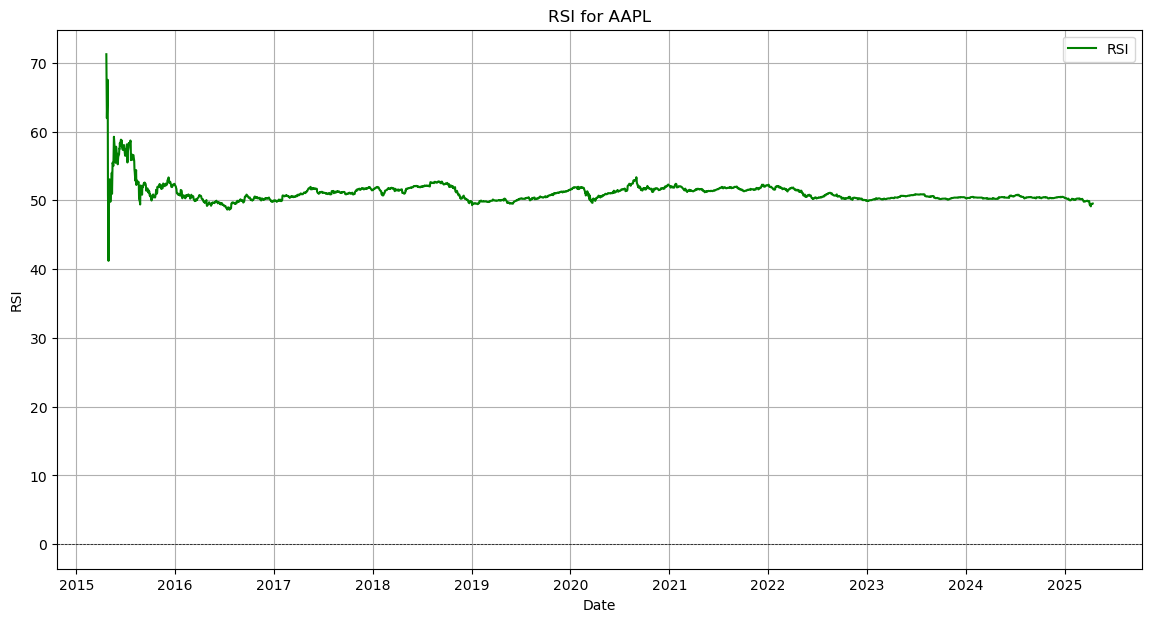

In [122]:
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['RSI'], label='RSI', color='green')
plt.axhline(0, color='black', lw=0.5, ls='--')
plt.title(f'RSI for {symbol}')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend()
plt.grid()
plt.show()

## Task 3a: train model

In [123]:
train_df = pd.DataFrame()
train_df['ds'] = df['Date']
train_df['y'] = df['Close']

model = Prophet()
model.fit(train_df)

19:56:44 - cmdstanpy - INFO - Chain [1] start processing
19:56:44 - cmdstanpy - INFO - Chain [1] done processing


## Task 3b: make prediction

In [124]:
predict_df = model.predict(model.make_future_dataframe(periods=365))
predict_df[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2015-04-20,22.848646,12.552190,33.993181
1,2015-04-21,22.958862,12.673790,32.719993
2,2015-04-22,23.159924,12.291945,33.273103
3,2015-04-23,23.214863,12.316796,33.023043
4,2015-04-24,23.387668,12.725255,33.673921
...,...,...,...,...
2874,2026-04-11,269.613876,250.235933,286.567921
2875,2026-04-12,269.800616,249.361210,285.598550
2876,2026-04-13,269.960643,250.321240,286.610855
2877,2026-04-14,270.113286,249.559624,286.159468


## Task 3c: plot prediction

/opt/anaconda3/envs/econ3086l01/lib/python3.12/site-packages/prophet/plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/opt/anaconda3/envs/econ3086l01/lib/python3.12/site-packages/prophet/plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



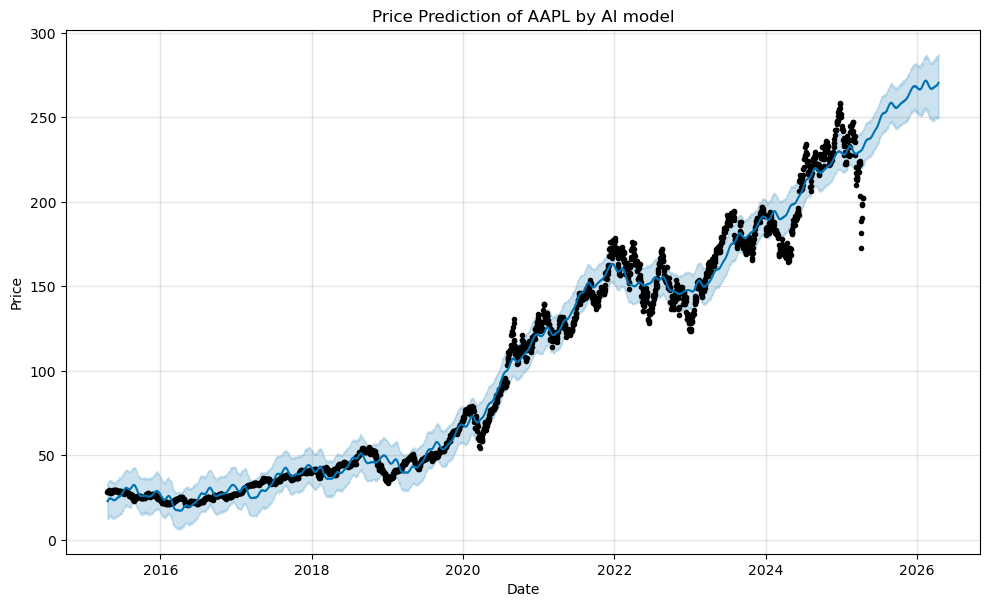

In [125]:
model.plot(predict_df)
plt.title(f'Price Prediction of {symbol} by AI model')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend
plt.show()

In [126]:
##Task 4 Sentiment analysis

In [127]:
##Task 4a Fetching data from the web

In [128]:
def fetch_news_data(ticker, days_back=30):
    # Replace with your actual API key
    NEWS_API_KEY = "db835285fd87424f9248cdeff8caa3eb"
    
    # Calculate date range
    end_date = datetime.datetime.now()
    start_date = end_date - datetime.timedelta(days=days_back)
    
    # Format dates for API
    from_date = start_date.strftime('%Y-%m-%d')
    to_date = end_date.strftime('%Y-%m-%d')
    
    # Fetch news articles
    url = f"https://newsapi.org/v2/everything?q={ticker}&from={from_date}&to={to_date}&language=en&sortBy=publishedAt&apiKey={NEWS_API_KEY}"
    response = requests.get(url)
    news_data = response.json()
    
    # Create DataFrame from news data
    if news_data['status'] == 'ok':
        articles = news_data['articles']
        news_df = pd.DataFrame([
            {
                'date': datetime.datetime.strptime(article['publishedAt'][:19], '%Y-%m-%dT%H:%M:%S'),
                'title': article['title'],
                'description': article['description'],
                'content': article['content'],
                'source': article['source']['name'],
                'url': article['url']
            }
            for article in articles if article['description'] is not None
        ])
        return news_df
    else:
        print(f"Error fetching news: {news_data['message']}")
        return pd.DataFrame()

# Fetch news for your ticker
 # Replace with your ticker
news_df = fetch_news_data(symbol)


In [129]:
##Task 4b Implement Sentiment Analysis


In [130]:
def analyze_sentiment(text):
    # Initialize sentiment analyzers
    sia = SentimentIntensityAnalyzer()
    
    # Skip empty content
    if pd.isna(text) or text == "":
        return {
            'vader_compound': 0,
            'vader_pos': 0,
            'vader_neg': 0,
            'vader_neu': 0,
            'textblob_polarity': 0
        }
    
    # VADER sentiment analysis
    vader_scores = sia.polarity_scores(text)
    
    # TextBlob sentiment analysis
    textblob_analysis = TextBlob(text)
    textblob_polarity = textblob_analysis.sentiment.polarity
    
    return {
        'vader_compound': vader_scores['compound'],
        'vader_pos': vader_scores['pos'],
        'vader_neg': vader_scores['neg'],
        'vader_neu': vader_scores['neu'],
        'textblob_polarity': textblob_polarity
    }

# Apply sentiment analysis to news data
sentiment_results = []

for _, row in news_df.iterrows():
    # Combine title and description for more context
    full_text = f"{row['title']} {row['description']}"
    sentiment = analyze_sentiment(full_text)
    sentiment['date'] = row['date']
    sentiment_results.append(sentiment)

# Create sentiment DataFrame
sentiment_df = pd.DataFrame(sentiment_results)

# Aggregate by date (daily average)
daily_sentiment = sentiment_df.groupby(sentiment_df['date'].dt.date).agg({
    'vader_compound': 'mean',
    'textblob_polarity': 'mean'
}).reset_index()

# Convert date to datetime for merging
daily_sentiment['date'] = pd.to_datetime(daily_sentiment['date'])


In [131]:
##Task 4c  Merge Sentiment Data with Price Data

In [132]:
# Assuming your stock data is in a DataFrame called 'df' with a 'Date' column
# Convert 'Date' to datetime if it's not already
df['Date'] = pd.to_datetime(df['Date'])

# Merge price data with sentiment data
merged_df = pd.merge(
    df, 
    daily_sentiment, 
    left_on='Date', 
    right_on='date', 
    how='left'
)

# Forward fill sentiment values for days without news
merged_df[['vader_compound', 'textblob_polarity']] = merged_df[['vader_compound', 'textblob_polarity']].fillna(method='ffill')


/var/folders/p1/4cy8z0fs22zc288p31mt_wqw0000gn/T/ipykernel_53764/1902490965.py:15: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [133]:
##Task 4d Visualize Sentiment with Price Trends

In [142]:
def visualize_sentiment_and_price(data, ticker):
    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    
    # Add price line
    fig.add_trace(
        go.Scatter(
            x=data['Date'], 
            y=data['Close'], 
            name="Price",
            line=dict(color='blue')
        ),
        secondary_y=False
    )
    
    # Add sentiment line (VADER compound)
    fig.add_trace(
        go.Scatter(
            x=data['Date'], 
            y=data['vader_compound'], 
            name="VADER Sentiment",
            line=dict(color='green', dash='dot')
        ),
        secondary_y=True
    )
    
    # Add TextBlob sentiment
    fig.add_trace(
        go.Scatter(
            x=data['Date'], 
            y=data['textblob_polarity'], 
            name="TextBlob Sentiment",
            line=dict(color='red', dash='dash')
        ),
        secondary_y=True
    )
    
    # Add layout details
    fig.update_layout(
        title=f"{ticker} Price vs Sentiment Analysis",
        xaxis_title="Date",
        legend=dict(x=0.01, y=0.99),
        hovermode="x unified"
    )
    
    # Set y-axes titles
    fig.update_yaxes(title_text="Price", secondary_y=False)
    fig.update_yaxes(title_text="Sentiment Score", secondary_y=True)
    
    return fig

# Visualize the data
sentiment_price_fig = visualize_sentiment_and_price(merged_df, symbol)
sentiment_price_fig.show()


In [135]:
# Resample sentiment data to hourly intervals
sentiment_df['hour'] = sentiment_df['date'].dt.floor('H')
hourly_sentiment = sentiment_df.groupby('hour').agg({
    'vader_compound': 'mean',
    'textblob_polarity': 'mean'
}).reset_index()

# Visualize hourly sentiment
def plot_hourly_sentiment(data, ticker):
    fig = go.Figure()
    
    fig.add_trace(
        go.Bar(
            x=data['hour'],
            y=data['vader_compound'],
            name='VADER Sentiment',
            marker_color='green'
        )
    )
    
    fig.update_layout(
        title=f"{ticker} Hourly Sentiment Scores",
        xaxis_title="Date Time",
        yaxis_title="Sentiment Score",
        hovermode="x unified"
    )
    
    return fig

hourly_sentiment_fig = plot_hourly_sentiment(hourly_sentiment, symbol)
hourly_sentiment_fig.show()


/var/folders/p1/4cy8z0fs22zc288p31mt_wqw0000gn/T/ipykernel_53764/1169594303.py:2: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.



In [136]:
def generate_sentiment_signals(data, threshold=0.2):
    # Create a new column for sentiment signals
    data['sentiment_signal'] = 0
    
    # Buy signal when sentiment is strongly positive
    data.loc[data['vader_compound'] > threshold, 'sentiment_signal'] = 1
    
    # Sell signal when sentiment is strongly negative
    data.loc[data['vader_compound'] < -threshold, 'sentiment_signal'] = -1
    
    return data

# Generate signals
merged_df = generate_sentiment_signals(merged_df)

# Visualize signals on price chart
def visualize_sentiment_signals(data, ticker):
    fig = go.Figure()
    
    # Add price line
    fig.add_trace(
        go.Scatter(
            x=data['Date'],
            y=data['Close'],
            name='Price',
            line=dict(color='blue')
        )
    )
    
    # Add buy signals
    buy_signals = data[data['sentiment_signal'] == 1]
    fig.add_trace(
        go.Scatter(
            x=buy_signals['Date'],
            y=buy_signals['Close'],
            mode='markers',
            name='Buy Signal',
            marker=dict(color='green', size=10, symbol='triangle-up')
        )
    )
    
    # Add sell signals tenary operator 
    sell_signals = data[data['sentiment_signal'] == -1]
    fig.add_trace(
        go.Scatter(
            x=sell_signals['Date'],
            y=sell_signals['Close'],
            mode='markers',
            name='Sell Signal',
            marker=dict(color='red', size=10, symbol='triangle-down')
        )
    )
    
    fig.update_layout(
        title=f"{ticker} Price with Sentiment-Based Trading Signals",
        xaxis_title="Date",
        yaxis_title="Price",
        hovermode="x unified"
    )
    
    return fig

signal_fig = visualize_sentiment_signals(merged_df, symbol)
signal_fig.show()


In [137]:
def analyze_sentiment_price_correlation(data):
    # Calculate correlation between sentiment and price
    correlation = data[['Close', 'vader_compound', 'textblob_polarity']].corr()
    
    # Calculate lagged correlations to see if sentiment predicts future price
    lag_results = {}
    
    for lag in range(1, 6):  # Test 1-5 day lags
        data[f'price_change_{lag}d'] = data['Close'].pct_change(lag)
        
        # Correlation between current sentiment and future price changes
        lag_corr = data[[f'price_change_{lag}d', 'vader_compound', 'textblob_polarity']].corr()
        lag_results[lag] = {
            'vader': lag_corr.loc[f'price_change_{lag}d', 'vader_compound'],
            'textblob': lag_corr.loc[f'price_change_{lag}d', 'textblob_polarity']
        }
    
    return correlation, lag_results

# Calculate correlations
correlation, lag_correlations = analyze_sentiment_price_correlation(merged_df)
print("Correlation Matrix:")
print(correlation)

print("\nLagged Correlations (Sentiment → Future Price):")
for lag, values in lag_correlations.items():
    print(f"{lag}-day lag: VADER={values['vader']:.4f}, TextBlob={values['textblob']:.4f}")


Correlation Matrix:
                   Close  vader_compound  textblob_polarity
Close                1.0            -1.0                1.0
vader_compound      -1.0             1.0               -1.0
textblob_polarity    1.0            -1.0                1.0

Lagged Correlations (Sentiment → Future Price):
1-day lag: VADER=-1.0000, TextBlob=1.0000
2-day lag: VADER=-1.0000, TextBlob=1.0000
3-day lag: VADER=1.0000, TextBlob=-1.0000
4-day lag: VADER=-1.0000, TextBlob=1.0000
5-day lag: VADER=1.0000, TextBlob=-1.0000
